In [ ]:
!pip install datasets
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt



# Load SNLI dataset
snli = load_dataset("snli")

# Debug: Print unique labels
print("Unique labels in SNLI dataset:", set(snli['train']['label']))

# Filter valid labels (0: entailment, 1: contradiction, 2: neutral, -1 is invalid)
valid_labels = {0: "entailment", 1: "contradiction", 2: "neutral"}

filtered_data = [
    (p, h, l) for p, h, l in zip(snli['train']['premise'], snli['train']['hypothesis'], snli['train']['label'])
    if l in valid_labels and p is not None and h is not None
]

# Ensure valid data exists
if not filtered_data:
    raise ValueError("❌ No valid data found! Check if dataset is correctly loaded.")

# Unzip data
premises, hypotheses, labels = zip(*filtered_data)

# Tokenize and preprocess data
def preprocess_texts(premises, hypotheses, vocab_size=10000, max_len=50):
    tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
    tokenizer.fit_on_texts(premises + hypotheses)

    premise_seq = tokenizer.texts_to_sequences(premises)
    hypothesis_seq = tokenizer.texts_to_sequences(hypotheses)

    premise_padded = pad_sequences(premise_seq, maxlen=max_len, padding='post')
    hypothesis_padded = pad_sequences(hypothesis_seq, maxlen=max_len, padding='post')

    return premise_padded, hypothesis_padded, tokenizer

# Preprocess data
premise_padded, hypothesis_padded, tokenizer = preprocess_texts(list(premises), list(hypotheses))

# Combine premise and hypothesis as input features
X = np.concatenate((premise_padded, hypothesis_padded), axis=1)
y = np.array(labels)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and train LSTM model
def build_lstm_model(vocab_size, embedding_dim=100, max_len=50):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(64))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax')) # 3 classes: entailment, contradiction, neutral


    model.build(input_shape=(None,max_len * 2))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

vocab_size = 10000
model = build_lstm_model(vocab_size)
model.summary()

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=32, steps_per_epoch=500)

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"LSTM Model Accuracy: {accuracy * 100:.2f}%")

# 🔹 **User Input Prediction Function**
def predict_snli(model, tokenizer, premise, hypothesis, max_len=50):
    premise_seq = tokenizer.texts_to_sequences([premise])
    hypothesis_seq = tokenizer.texts_to_sequences([hypothesis])

    premise_padded = pad_sequences(premise_seq, maxlen=max_len, padding='post')
    hypothesis_padded = pad_sequences(hypothesis_seq, maxlen=max_len, padding='post')

    X_input = np.concatenate((premise_padded, hypothesis_padded), axis=1)

    prediction = model.predict(X_input)
    predicted_label = np.argmax(prediction, axis=1)[0]

    label_map = {0: "Entailment", 1: "Contradiction", 2: "Neutral"}

    print("\n💡 **Prediction Result** 💡")
    print(f"📝 Premise: {premise}")
    print(f"📝 Hypothesis: {hypothesis}")
    print(f"✅ Prediction: {label_map[predicted_label]} (Confidence: {max(prediction[0]) * 100:.2f}%)")

# 🔹 **User Input**
user_premise = input("Enter a premise sentence: ")
user_hypothesis = input("Enter a hypothesis sentence: ")

predict_snli(model, tokenizer, user_premise, user_hypothesis)


# Define EarlyStopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3) # Stop if val_loss doesn't improve for 3 epochs

# Train and capture history
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

# Plot training & validation accuracy values
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Unique labels in SNLI dataset: {0, 1, 2, -1}


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100, 128)       │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,171,011 (4.47 MB)

 Trainable params: 1,171,011 (4.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
500/500 ━━━━━━━━━━━━━━━━━━━━ 395s 782ms/step - accuracy: 0.3316 - loss: 1.1000 - val_accuracy: 0.3313 - val_loss: 1.0987
Epoch 2/3
500/500 ━━━━━━━━━━━━━━━━━━━━ 371s 743ms/step - accuracy: 0.3333 - loss: 1.0993 - val_accuracy: 0.3313 - val_loss: 1.0989
Epoch 3/3
500/500 ━━━━━━━━━━━━━━━━━━━━ 388s 776ms/step - accuracy: 0.3336 - loss: 1.0992 - val_accuracy: 0.3338 - val_loss: 1.0988
3434/3434 ━━━━━━━━━━━━━━━━━━━━ 266s 77ms/step - accuracy: 0.3330 - loss: 1.0989
LSTM Model Accuracy: 33.38%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step

💡 **Prediction Result** 💡
📝 Premise: All cats are mammals.
📝 Hypothesis: If cats are mammals, then they will have mammary glands.
✅ Prediction: Entailment (Confidence: 34.21%)
Epoch 1/10
11398/13735 ━━━━━━━━━━━━━━━━━━━━ 9:04 233ms/step - accuracy: 0.3342 - loss: 1.0989

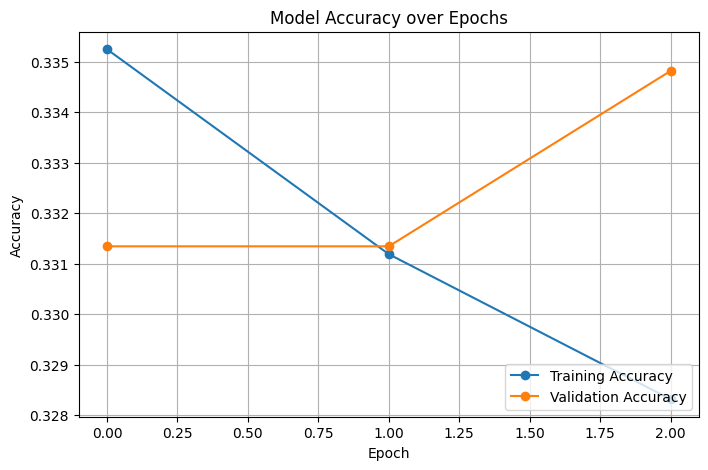

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy(history):
    plt.figure(figsize=(8,5))
    plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Model Accuracy over Epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# --- Usage ---
# After your model.fit(), pass the 'history' to this function:

# Example:
#history = model.fit(...)
plot_accuracy(history)


In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', marker='o')
    plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show(block=True)  # <--- important for script users


In [ ]:
\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\